## Post-Processed Stitching
This notebook stitches measurements AFTER reconstruction is performed for each segment.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset

# Platform imports
import os, glob
from os.path import expanduser
import numpy as np

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

## Load Data

In [2]:
# Define user for path setting
dataset_path = expanduser("~") + '/datasets/motiondeblur/'

# Define output directory
output_path = os.path.join(dataset_path,'output')

# Define which dataset to use
dataset_type = 'stop'
dataset_label = 'res'

# Find files in this directory
saved_output_files = glob.glob(os.path.join(output_path, '*' + dataset_type + '*.npz'))
filtered_output_files = sorted([file for file in saved_output_files if dataset_label in file])

print('Found %d files.'% len(filtered_output_files))
segment_data = []
roi_list = []
measurement_list = []
recon_list = []
segment_index_list = []
for output_file in filtered_output_files:
    segment_data = np.load(output_file)
    roi_list.append(yp.Roi(**segment_data['roi'].item()))
    measurement_list.append(segment_data['y'])
    recon_list.append(segment_data['object_recovered'])
    segment_index_list.append(segment_data['segment_index'])

# Move all ROI objects to origin
full_roi = sum(roi_list)
for roi in roi_list:
    roi -= full_roi.start
    roi.input_shape = full_roi.shape

Found 7 files.


## Apply Segment Offsets To Correct Mis-Alignment

In [3]:
segment_offset_x = -235
segment_offset_y = -25

for roi, segment_index in zip(roi_list, segment_index_list):
    if segment_index % 2 == 0:
        roi -= (0, segment_offset_x)
    else:
        roi += (0, segment_offset_x)
        
    roi += (segment_index * segment_offset_y, 0)
    
# Move all ROI objects to origin
full_roi = sum(roi_list)
for roi in roi_list:
    roi -= full_roi.start
    roi.input_shape = full_roi.shape

## Register Frames

In [5]:
shift_list = md.recon.register_roi_list(recon_list, roi_list,tolerance=(600,600))
for roi, shift in zip(roi_list, shift_list):
    roi -= shift

## Perform Stitching

<IPython.core.display.Javascript object>


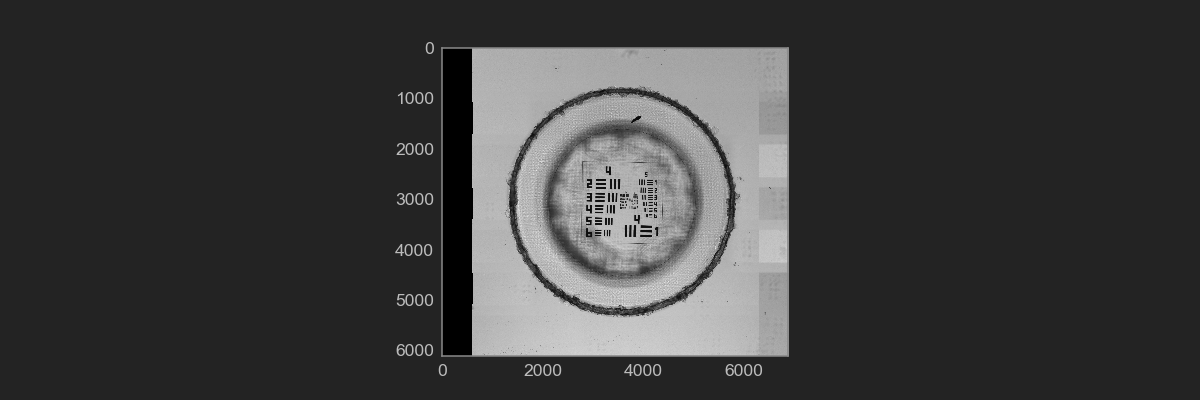

In [8]:
import ndoperators as ops

# Generate segmenetation Operator
G = ops.Segmentation(roi_list, full_roi.shape, alpha_blend_size=500)

# Concatenate measurements
y = ops.VecStack(recon_list)

# Perform reconstruction
stitched = G.inv * y

plt.figure()
plt.imshow(stitched)

In [7]:
md.recon.normalize_segments(roi_list, recon_list, write_results=True)

[array([1., 1., 1., ..., 1., 1., 1.], dtype=float32),
 array([0.92906338, 0.92909288, 0.92912239, ..., 1.09644269, 1.09647219,
        1.0965017 ]),
 array([1.17116919, 1.1711378 , 1.17110641, ..., 0.92280746, 0.92275134,
        0.92269522]),
 array([1.02428828, 1.02431891, 1.02434954, ..., 1.06692056, 1.06690148,
        1.06688239]),
 array([1.17584565, 1.17582941, 1.17581314, ..., 0.9204121 , 0.92034199,
        0.92027187]),
 array([0.93324529, 0.93331659, 0.93338788, ..., 1.10476639, 1.10474817,
        1.10472993]),
 array([1.11962767, 1.11967705, 1.11972641, ..., 1.0816977 , 1.08163683,
        1.08157595])]

<IPython.core.display.Javascript object>


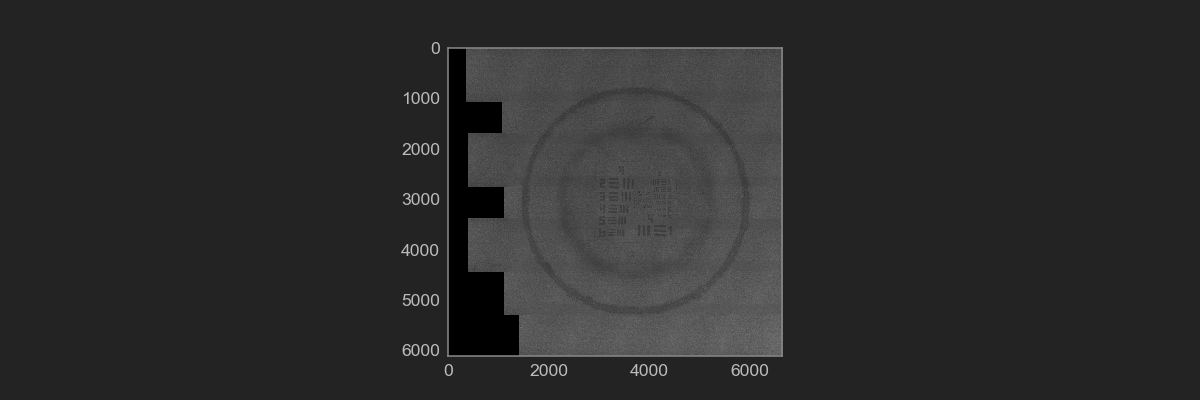

In [146]:
flat_field_y, flat_field_x = md.recon.estimateBackgroundPolynomial(stitched)

plt.figure()
plt.imshow(yp.real(stitched / (flat_field_y * flat_field_x)))

In [148]:
static = stitched / (flat_field_y * flat_field_x)

## Perform Ramp-Based Normalization
We can normalize frames by modeling intensity changes as linear intensity ramps across individual strips. We first set the intercept at the x=0 position and then

## Generate Figure With Scale Bar

In [10]:
from libwallerlab.utilities.noise import snr
snr(stitched[:500,-500:])

39.00756808944679

<IPython.core.display.Javascript object>


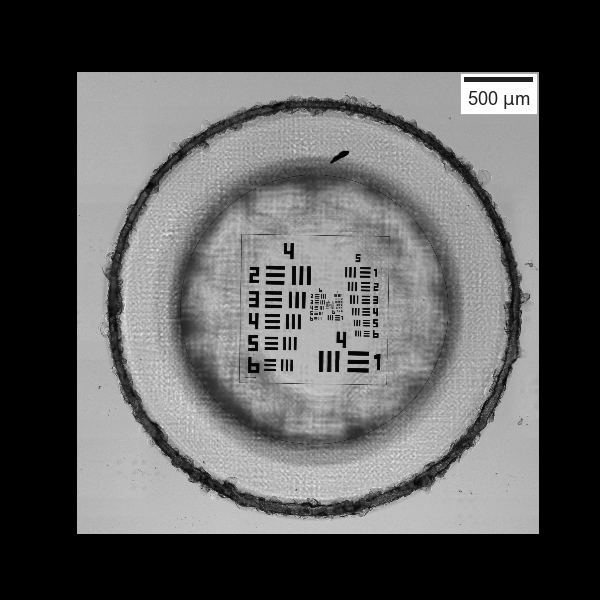

<IPython.core.display.Javascript object>


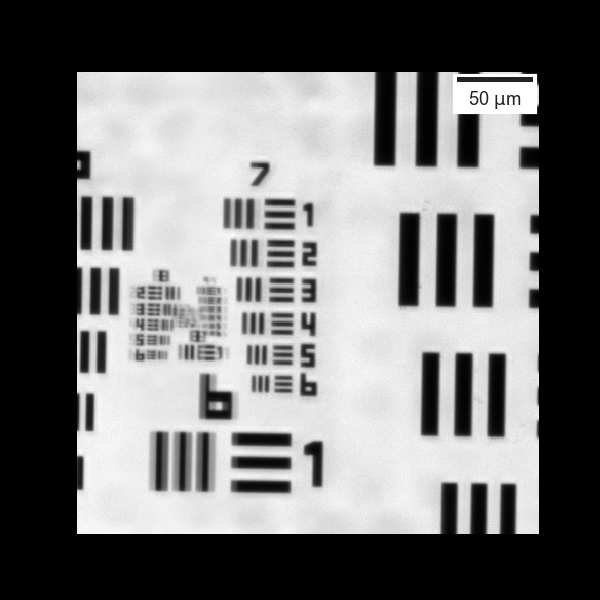

In [16]:


from matplotlib_scalebar.scalebar import ScaleBar

label = 'sns'
# Crop ROI
crop_roi = yp.Roi(start=(500,1000),shape=(5000,5000))

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.imshow(stitched[crop_roi.slice])
    scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    plt.savefig(os.path.join(output_path, 'figure_' + label +'.png'), transparent=True, dpi=300)
    
# Crop ROI
zoom_roi = yp.Roi(start=(2780,3640),shape=(450,450))

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.imshow(stitched[zoom_roi.slice])
    scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    plt.savefig(os.path.join(output_path, 'figure_' + label + '_zoom.png'), transparent=True, dpi=300)
    

## Save Reconstruction

In [39]:
output_path

'/Users/zfphil/datasets/motiondeblur/output'

In [8]:
import tifffile
stitched_8 = stitched.copy()
stitched_8 -= np.min(stitched_8)
stitched_8 /= 0.99 *np.max(stitched_8)
stitched_8 *= 255
stitched_8 = stitched_8.astype(np.uint8)

tifffile.imsave(os.path.join(output_path + '/stitched_recon_coded.tiff'), stitched_8)